In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import scipy.stats as stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from heapq import nsmallest

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.externals.six import StringIO

import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

np.set_printoptions(threshold=1000)

In [3]:
#first look at data, let's look at just the first 2 rows
nov16 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201611a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
], nrows=2)

In [4]:
nov16

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
0,20161102,640,CP:C2YMD-A/B,StandardType2,Part,"-7.204457,53.863850","The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102,640,CP:C4ZH3,StandardType2,OOS,"-7.361237,53.994044","Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044


In [5]:
#load all data with correct headers (I decided the column names based on info about dataset and looking at first 2 rows above)
nov16 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201611a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])

In [6]:
nov16.head()

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
0,20161102,640,CP:C2YMD-A/B,StandardType2,Part,"-7.204457,53.863850","The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102,640,CP:C4ZH3,StandardType2,OOS,"-7.361237,53.994044","Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
2,20161102,640,CP:C4547-A/B,StandardType2,OOC,"-7.082769,53.834939","Main Street, Virginia, County Cavan",-7.082769,53.834939
3,20161102,640,CP:C6GPC,StandardType2,Part,"-8.686061,52.358365","The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365
4,20161102,640,CP:C6BTQ,StandardType2,Part,"-8.520562,51.709117","Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117


In [7]:
nov16.shape

(1213520, 9)

In [8]:
nov16.columns

Index([u'Datetime', u'Time', u'ChargePointID', u'ChargePointType', u'Status',
       u'Latitude_Longitude', u'Address', u'Latitude', u'Longitude'],
      dtype='object')

In [9]:
#now i need to add the other months
dec16 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201612a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])

In [10]:
dec16.head()

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
0,20161201,0,CP:C67D2,StandardType2,OOC,"-6.955983,52.702794","The Parade, Bagenalstown, County Carlow",-6.955983,52.702794
1,20161201,0,CP:C4GTM,StandardType2,OOC,"-6.736986,52.801581","Inner Relief Road, Tullow, County Carlow",-6.736986,52.801581
2,20161201,0,CP:C4ZH3,StandardType2,OOS,"-7.361237,53.994044","Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
3,20161201,0,CP:C4W54,StandardType2,OOC,"-9.647069,52.683379","Public Car Park, East End, Kilkee, County Clare",-9.647069,52.683379
4,20161201,0,CP:C6WY4,StandardType2,OOC,"-9.290289,53.027069","Hydro Hotel, Main Street, Lisdoonvarna, County...",-9.290289,53.027069


In [11]:
print('In the head above, it looks like some of the times are 0, but after looking at the original data files, the 0s represent midnight')

In the head above, it looks like some of the times are 0, but after looking at the original data files, the 0s represent midnight


In [12]:
dec16.shape

(1085735, 9)

In [13]:
dec16.columns
#I named the data column 'Datetime' because later on this will be helpful when adding the 'Time' column to 'Datetime'

Index([u'Datetime', u'Time', u'ChargePointID', u'ChargePointType', u'Status',
       u'Latitude_Longitude', u'Address', u'Latitude', u'Longitude'],
      dtype='object')

In [14]:
#two ways to add decemeber rows to november rows
#1: append
#nov16.append(dec16,ignore_index=True)
#2: concat --> this one seems faster and is more recommended
full_data = pd.concat([nov16,dec16])

In [15]:
full_data.head() #november data up top looks good

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
0,20161102,640,CP:C2YMD-A/B,StandardType2,Part,"-7.204457,53.863850","The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102,640,CP:C4ZH3,StandardType2,OOS,"-7.361237,53.994044","Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
2,20161102,640,CP:C4547-A/B,StandardType2,OOC,"-7.082769,53.834939","Main Street, Virginia, County Cavan",-7.082769,53.834939
3,20161102,640,CP:C6GPC,StandardType2,Part,"-8.686061,52.358365","The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365
4,20161102,640,CP:C6BTQ,StandardType2,Part,"-8.520562,51.709117","Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117


In [16]:
full_data.tail() #december data on the bottom looks good! except there are a bunch of NaNs, I'll take care of those later

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1085730,20161227,1445,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1085731,20161227,1735,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1085732,20161228,1435,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1085733,20161228,1440,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1085734,20161228,1700,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [17]:
#now let's load up the rest of the months and add them all to the full_data df
jan17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201701a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
feb17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201702a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
march17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201703a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
april17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201704a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
may17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201705a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
june17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201706a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
july17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201707a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
aug17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201708a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
sept17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201709a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
oct17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201710a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
nov17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201711a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])
dec17 = pd.read_csv('/Users/alexandrasmith/Documents/DataScience/Intro_to_Data_Science/irish_EV_stations_data/201712a.txt',sep='\t',names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address","Latitude","Longitude"
])

/Applications/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
#from working through the data i know that there are a bunch of rows without a time that I need to remove
#at the bottom of the month of august (all are dated 2017-08-31)
aug17.tail()
#yup, the bottom rows are screwed up

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1232868,CP:C24W8,2017-08-31,Occ,20,40,22,15,-8.482733,51.919755
1232869,CP:SC53,2017-08-31,Part,21,10,22,05,-6.953681,55.049487
1232870,CP:C87HD,2017-08-31,Part,21,15,23,59,-8.852424,53.514180
1232871,CP:C3BMR-A/B,2017-08-31,Part,22,30,23,15,-6.255804,53.332326
1232872,Unknown,2017-08-31,Unknown,09,55,10,00,0.000000,0.000000


In [19]:
aug17.shape

(1232873, 9)

In [20]:
#find where the data starts going bad
#aug17.loc[aug17['Time'] == 955]
aug17[-1570:]

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1231303,20170831,2359,CP:C9LZK,CHAdeMO,Occ,"-8.189447,52.864558","Abbey Court Hotel, Dublin Road, Nenagh, County...",-8.189447,52.864558
1231304,20170831,2359,CP:RC08,CHAdeMO,OOS,"-6.217682,54.367680","Barbican Centra, Dromore Road (A1), Banbridge,...",-6.217682,54.367680
1231305,20170831,955,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1231306,CP:C67D2,2017-08-31,OOC,00,00,03,40,-6.955983,52.702794
1231307,CP:C67D2,2017-08-31,OOC,20,25,23,59,-6.955983,52.702794
1231308,CP:C6FD3,2017-08-31,OOS,00,00,09,55,-6.933468,52.836332
1231309,CP:C6FD3,2017-08-31,OOS,10,00,23,59,-6.933468,52.836332
1231310,CP:C9X23,2017-08-31,OOC,00,00,09,55,-8.983370,52.845081
1231311,CP:C9X23,2017-08-31,OOC,10,00,23,59,-8.983370,52.845081
1231312,CP:C4FVM,2017-08-31,OOS,00,00,09,55,-9.346292,52.928911


In [21]:
aug17[-1568:] #find the exact index where the data gets funky

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1231305,20170831,955,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1231306,CP:C67D2,2017-08-31,OOC,00,00,03,40,-6.955983,52.702794
1231307,CP:C67D2,2017-08-31,OOC,20,25,23,59,-6.955983,52.702794
1231308,CP:C6FD3,2017-08-31,OOS,00,00,09,55,-6.933468,52.836332
1231309,CP:C6FD3,2017-08-31,OOS,10,00,23,59,-6.933468,52.836332
1231310,CP:C9X23,2017-08-31,OOC,00,00,09,55,-8.983370,52.845081
1231311,CP:C9X23,2017-08-31,OOC,10,00,23,59,-8.983370,52.845081
1231312,CP:C4FVM,2017-08-31,OOS,00,00,09,55,-9.346292,52.928911
1231313,CP:C4FVM,2017-08-31,OOS,10,00,23,59,-9.346292,52.928911
1231314,CP:C6Q3G,2017-08-31,OOS,00,00,09,55,-8.889570,51.620831


In [22]:
#copy all the good rows to a Cleaned version of the aug17 dataset
aug17Cleaned = aug17[:-1568]

In [23]:
aug17Cleaned.tail()

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1231300,20170831,2359,CP:RC08,FastAC43,OOS,"-6.217682,54.367680","Barbican Centra, Dromore Road (A1), Banbridge,...",-6.217682,54.367680
1231301,20170831,2359,CP:RC08,ComboCCS,OOS,"-6.217682,54.367680","Barbican Centra, Dromore Road (A1), Banbridge,...",-6.217682,54.367680
1231302,20170831,2359,CP:C8W2F,CHAdeMO,OOS,"-8.955524,53.667639","McHugh's Texaco Service Station, Galway Road, ...",-8.955524,53.667639
1231303,20170831,2359,CP:C9LZK,CHAdeMO,Occ,"-8.189447,52.864558","Abbey Court Hotel, Dublin Road, Nenagh, County...",-8.189447,52.864558
1231304,20170831,2359,CP:RC08,CHAdeMO,OOS,"-6.217682,54.367680","Barbican Centra, Dromore Road (A1), Banbridge,...",-6.217682,54.367680


In [24]:
#putting all the months (14) of data together
full_data = pd.concat([full_data,jan17,feb17,march17,april17,may17,june17,july17,aug17Cleaned,sept17,oct17,dec17])

In [25]:
#awesome, now let's take a look
full_data.tail()

,Datetime,Time,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude
1591585,20171225,2055,CP:C2D7M,CHAdeMO,OOC,"-6.216111,53.412778","Topaz Service Station, Clonshaugh Road, Cloghr...",-6.216111,53.412778
1591586,20171225,2055,CP:C92P9,CHAdeMO,Occ,"-7.300103,53.014561","Midway Complex, M7 Junction 17 (N77/R423), Por...",-7.300103,53.014561
1591587,20171225,2055,CP:CBXYW,CHAdeMO,OOC,"-7.783760,53.724529","Camlin Esso/Spar Service Station, Dublin Road,...",-7.783760,53.724529
1591588,20171225,2055,CP:RC15,CHAdeMO,Occ,"-5.922442,54.629701","Fort Service Station, 234 Shore Road, Belfast,...",-5.922442,54.629701
1591589,20171209,555,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


In [26]:
full_data.shape #danggggg, that's a lot of entries...over 17 million

(17312968, 9)

In [27]:
#check types of columns
full_data.dtypes #okay so I'm going to want to change the datetime to type datetime at some point

Datetime               object
Time                   object
ChargePointID          object
ChargePointType        object
Status                 object
Latitude_Longitude     object
Address                object
Latitude              float64
Longitude             float64
dtype: object

In [28]:
#let's get rid of a duplicate column
del full_data['Latitude_Longitude'] #delete duplicate column of latitude and longitude

In [29]:
full_data.head(10)

,Datetime,Time,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude
0,20161102,640,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102,640,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
2,20161102,640,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939
3,20161102,640,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365
4,20161102,640,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117
5,20161102,640,CP:C7GRZ,StandardType2,OOC,"Navenny Street, Ballybofey, County Donegal",-7.783045,54.797965
6,20161102,640,CP:C7DGY,StandardType2,OOC,"Market Yard Car Park, Main Street, Ballyshanno...",-8.188621,54.501145
7,20161102,640,CP:C9HRF,StandardType2,OOS,"The Aura Lesiure Centre, Ballymacool Street, L...",-7.751151,54.946769
8,20161102,640,CP:C75HT,StandardType2,OOS,"Hospital Car Park, Kilmacrennan Road, Letterke...",-7.731468,54.961006
9,20161102,640,CP:C7FDW,StandardType2,OOC,"Justice Walsh Car Park, Off Bank Lane, Letterk...",-7.734554,54.951508


In [30]:
#convert Datetime to str to combine date (Datetime) and time (Time)
full_data.Datetime = full_data.Datetime.astype(str)

#convert Time to str to combine date (Datetime) and time (Time)
full_data.Time = full_data.Time.astype(str)

In [31]:
full_data.dtypes
#even though the type of Datetime and Time is still 'object', it seemed to help with respect to eliminating the following error when adding Time to Datetime below:
#TypeError: sequence item 0: expected string, int found

Datetime            object
Time                object
ChargePointID       object
ChargePointType     object
Status              object
Address             object
Latitude           float64
Longitude          float64
dtype: object

In [32]:
#add Time to Datetime column
full_data['Datetime'] = full_data['Datetime'].str.cat(full_data['Time'].values.astype(str), sep='')

In [33]:
full_data.head()

,Datetime,Time,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude
0,20161102640,640,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102640,640,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
2,20161102640,640,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939
3,20161102640,640,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365
4,20161102640,640,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117


In [34]:
#now I don't need the Time column anymone (since it was added to the Datetime column)
del full_data['Time']

In [35]:
full_data.head()

,Datetime,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude
0,20161102640,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850
1,20161102640,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044
2,20161102640,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939
3,20161102640,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365
4,20161102640,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117


In [36]:
full_data.dtypes
#now Datetime is ready to be converted to type datetime

Datetime            object
ChargePointID       object
ChargePointType     object
Status              object
Address             object
Latitude           float64
Longitude          float64
dtype: object

In [37]:
"""I tried converting Datetime to type datetime with a single line but got an error
so I eventually proceeded this way:"""

full_data['Date'] = full_data.Datetime.str.slice(0,8)
full_data['Time'] = full_data.Datetime.str.slice(8)
full_data['Time'] = full_data['Time'].apply(lambda val: '{:0>4}'.format(val))
full_data['Datetime'] = full_data['Date'] + " " + full_data["Time"]

In [38]:
full_data.head()

,Datetime,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,Date,Time
0,20161102 0640,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,20161102,0640
1,20161102 0640,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,20161102,0640
2,20161102 0640,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,20161102,0640
3,20161102 0640,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,20161102,0640
4,20161102 0640,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,20161102,0640


In [39]:
#let's make sure the times at midnight (which looked like 0 before) made it through the transition
full_data.loc[full_data['Datetime'] == '20170101 0'] #-->a midnight time that did not make it through previously
#yup looks good

,Datetime,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,Date,Time


In [40]:
#now let's finally convert Datetime to type datetime in column FormattedDatetime
full_data['FormattedDatetime'] = pd.to_datetime(full_data.Datetime,format="%Y%m%d %H%M")

In [41]:
#let's check that it changed the type
full_data.dtypes
#YAY!

Datetime                     object
ChargePointID                object
ChargePointType              object
Status                       object
Address                      object
Latitude                    float64
Longitude                   float64
Date                         object
Time                         object
FormattedDatetime    datetime64[ns]
dtype: object

In [42]:
full_data.head()

,Datetime,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,Date,Time,FormattedDatetime
0,20161102 0640,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,20161102,0640,2016-11-02 06:40:00
1,20161102 0640,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,20161102,0640,2016-11-02 06:40:00
2,20161102 0640,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,20161102,0640,2016-11-02 06:40:00
3,20161102 0640,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,20161102,0640,2016-11-02 06:40:00
4,20161102 0640,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,20161102,0640,2016-11-02 06:40:00


In [43]:
#now we can get rid of the Datetime, Date, and Time columns
del full_data['Datetime']
del full_data['Date']
del full_data['Time']

full_data.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime
0,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,2016-11-02 06:40:00
1,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,2016-11-02 06:40:00
2,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,2016-11-02 06:40:00
3,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,2016-11-02 06:40:00
4,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,2016-11-02 06:40:00


In [44]:
#now I want to start looking at the pattern of when the charge points are being used or not

""""from the original description of the data:
The available status has been omitted as it can be implied by the absence of a record.

because of that, once I choose the chunk of data I want to work with,
I will add in the 'Available' records"""

print("What are the different values of 'Status':",full_data.Status.unique())
print()
print("How many of each value:\n",full_data.Status.value_counts())

What are the different values of 'Status': ['Part' 'OOS' 'OOC' 'Occ' nan]

How many of each value:
 Part    5247602
OOS     4900677
OOC     4226165
Occ     2932814
Name: Status, dtype: int64


In [45]:
"""let's take a look at the data per month.
is there more data in november and december (11 and 12) because we have two months of data for each?
is that not the case because of the possibility of OOS or OOC?
"""
full_data.groupby([full_data.FormattedDatetime.dt.month]).count()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime
FormattedDatetime,,,,,,,
1,1171376,1197349,1197349,1197349,1197865,1197865,1197865
2,1074354,1093466,1093466,1093466,1093546,1093546,1093546
3,1206475,1224596,1224596,1224596,1224835,1224835,1224835
4,1033588,1045865,1045865,1045865,1046061,1046061,1046061
5,1201633,1218803,1218803,1218803,1218812,1218812,1218812
6,1106024,1124141,1124141,1124141,1124418,1124418,1124418
7,899427,913344,913344,913344,915755,915755,915755
8,1211445,1231305,1231305,1231305,1231305,1231305,1231305
9,2766504,2810372,2810372,2810372,2810404,2810404,2810404


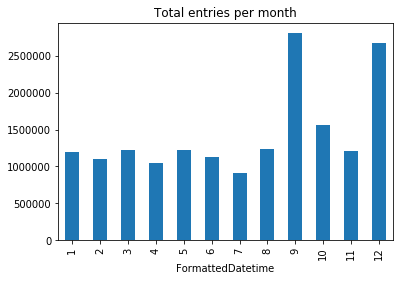

In [46]:
full_data.groupby([full_data.FormattedDatetime.dt.month])['Status'].count().plot(kind='bar', title='Total entries per month')

In [47]:
full_data.groupby(['Status']).count()

,ChargePointID,ChargePointType,Address,Latitude,Longitude,FormattedDatetime
Status,,,,,,
OOC,4186963,4226165,4226165,4226165,4226165,4226165
OOS,4737219,4900677,4900677,4900677,4900677,4900677
Occ,2914360,2932814,2932814,2932814,2932814,2932814
Part,5183821,5247602,5247602,5247602,5247602,5247602


In [48]:
#full_data['Month'] = full_data.FormattedDatetime.dt.month
#full_data['Year'] = full_data.FormattedDatetime.dt.year
#del full_data['Month']
#del full_data['Year']

#let's group the data by month and by status
full_data.groupby([full_data.FormattedDatetime.dt.month,'Status']).Status.count()

FormattedDatetime  Status
1                  OOC       337597
                   OOS       337707
                   Occ       197759
                   Part      324286
2                  OOC       319825
                   OOS       281129
                   Occ       177930
                   Part      314582
3                  OOC       285889
                   OOS       306760
                   Occ       249467
                   Part      382480
4                  OOC       258004
                   OOS       258553
                   Occ       185032
                   Part      344276
5                  OOC       402005
                   OOS       263825
                   Occ       186481
                   Part      366492
6                  OOC       265610
                   OOS       323846
                   Occ       186455
                   Part      348230
7                  OOC       224086
                   OOS       248676
                   Occ       151211
  

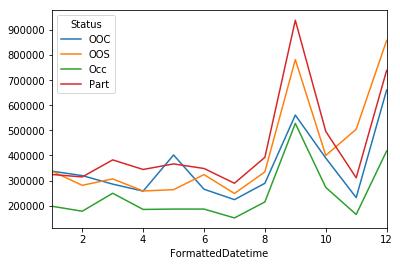

In [49]:
#let's plot the different charge statuses per month

full_data.groupby([full_data.FormattedDatetime.dt.month,'Status']).Status.count().unstack().plot()

In [50]:
print("Interesting. Based on the above graph, it looks like the incidences of OOS (out of service) increase when they are being used more frequently, which makes sense")

Interesting. Based on the above graph, it looks like the incidences of OOS (out of service) increase when they are being used more frequently, which makes sense


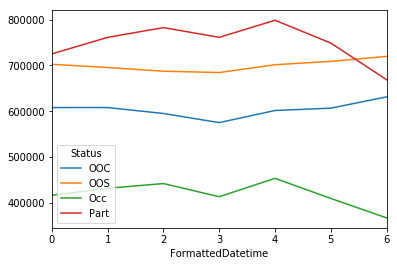

In [51]:
#let's plot the different charge statuses per day of week

full_data.groupby([full_data.FormattedDatetime.dt.dayofweek,'Status']).Status.count().unstack().plot()

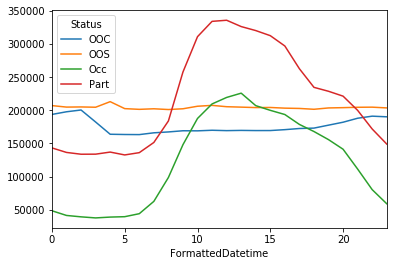

In [52]:
#let's plot the different charge statuses per hour

full_data.groupby([full_data.FormattedDatetime.dt.hour,'Status']).Status.count().unstack().plot()

In [53]:
full_data.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime
0,CP:C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,2016-11-02 06:40:00
1,CP:C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,2016-11-02 06:40:00
2,CP:C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,2016-11-02 06:40:00
3,CP:C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,2016-11-02 06:40:00
4,CP:C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,2016-11-02 06:40:00


In [54]:
#let's remove the first 3 characters in the ChargePointID column as they all have 'CP:' at the beginning, which is unnecessary
full_data['ChargePointID'] = full_data['ChargePointID'].str[3:]

In [55]:
full_data.head() #awesome!

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime
0,C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,2016-11-02 06:40:00
1,C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,2016-11-02 06:40:00
2,C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,2016-11-02 06:40:00
3,C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,2016-11-02 06:40:00
4,C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,2016-11-02 06:40:00


In [56]:
#now let's make the variable 'Status' into dummy variables

status_dummies = pd.get_dummies(full_data.Status).astype(int)
status_dummies.head()

,OOC,OOS,Occ,Part
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [57]:
#let's reappend the status features to the original dataset
full_data = pd.concat(
    [full_data,status_dummies],
    axis=1) #remember that concatenating columns means axis=1!
#full_data.drop('Status',inplace=True,axis=1) --> this would drop the Status column, but we will want that
full_data.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,2016-11-02 06:40:00,0,0,0,1
1,C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,2016-11-02 06:40:00,0,1,0,0
2,C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,2016-11-02 06:40:00,1,0,0,0
3,C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,2016-11-02 06:40:00,0,0,0,1
4,C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,2016-11-02 06:40:00,0,0,0,1


In [58]:
chargePoints = full_data.ChargePointID.unique()
addresses = full_data.Address.unique()
months = full_data.FormattedDatetime.dt.month.unique()
years = full_data.FormattedDatetime.dt.year.unique()

In [59]:
print("The chargePoints in the dataset: ")
print(chargePoints)

The chargePoints in the dataset: 
['C2YMD-A/B' 'C4ZH3' 'C4547-A/B' 'C6GPC' 'C6BTQ' 'C7GRZ' 'C7DGY' 'C9HRF'
 'C75HT' 'C7FDW' 'C7GDS' 'CBQYN' 'C7RK5' 'C79PY' 'C6TRS' 'C9XZ9' 'C7T9J'
 'C3RQP-A/B' 'C72Y7' 'C9XGC' 'C72QN' nan 'C6Y7D' 'C7P82' 'C7R26' 'CBSDM'
 'C4GFD' 'C6235' 'C82NL' 'C5XF7' 'C6S9V' 'C68YS' 'C7BCF' 'C3BMR-A/B'
 'CBK8P' 'C54BQ' 'C9FH8' 'C53XL' 'CBGBZ' 'C9D45' 'CBRP2' 'CBJHB' 'CBNQG'
 'C86VQ' 'C2NT8-A/B' 'C82W3' 'C7NT3' 'C7JWD' 'C8Z5Y' 'C9GLV' 'C6MNR'
 'C3XWQ-A/B' 'C4YZ8' 'C9YG8' 'C7KRJ' 'C7TKY' 'C85KF' 'C6NJV' 'C7D5J'
 'C9X23' 'SC46' 'SC52' 'SC91' 'SC139' 'SC21' 'SC09' 'SC127' 'SC48' 'SC103'
 'SC20' 'SC36' 'SC43' 'SC145' 'SC40' 'SC75' 'SC86' 'SC73' 'SC142' 'SC25'
 'SC109' 'SC07' 'SC26' 'SC74' 'SC157' 'SC102' 'SC89' 'RC03' 'SC41' 'SC37'
 'SC32' 'SC10' 'SC31' 'SC72' 'RC10' 'SC95' 'C932G' 'C7MV3' 'CB5YX' 'C924G'
 'C9PDB' 'C9N6X' 'CBXYW' 'CB5NK' 'RC08' 'RC16' 'CBQP6' 'C9YQN' 'CBTZ9'
 'RC17' 'C24W8' 'CBWV5' 'C8V2J' 'RC07' 'C7S3Z' 'C6T5Z' 'C5YNQ' 'C6J53'
 'C5Y4R' 'C63Z9' 'C5YCB' 'C6

In [60]:
print("The addresses in the dataset: ")
print(addresses)

The addresses in the dataset: 
['The Grove, Ballyjamesduff, County Cavan'
 'Off Farnham Street, Cavan Town, County Cavan'
 'Main Street, Virginia, County Cavan'
 'The Turrets, Off Main Street, Charleville, County Cork'
 'Fire Brigade Car Park, New Road, Kinsale, County Cork'
 'Navenny Street, Ballybofey, County Donegal'
 'Market Yard Car Park, Main Street, Ballyshannon, County Donegal'
 'The Aura Lesiure Centre, Ballymacool Street, Letterkenny, County Donegal'
 'Hospital Car Park, Kilmacrennan Road, Letterkenny, County Donegal'
 'Justice Walsh Car Park, Off Bank Lane, Letterkenny, County Donegal'
 'Main Street, Stranorlar, County Donegal'
 'Public Car Park, Mill Street, Balbriggan, County Dublin'
 'Irish Rail Booterstown DART Station, Rock Road, Blackrock, County Dublin'
 'Quickpark Dublin Airport, Old Airport Rd, Cloghran, County Dublin'
 'Topaz Service Station, Promenade Road, Dublin Port, Dublin 1, County Dublin'
 'St. Agnes Road, Crumlin, Dublin 12, County Dublin'
 'Main Street, Du

In [61]:
print("The months in the dataset: ")
print(months)

The months in the dataset: 
[11 12  1  2  3  4  5  6  7  8  9 10]


In [62]:
print("The years in the dataset: ")
print(years)

The years in the dataset: 
[2016 2017]


In [63]:
print("The overall dataset shape: ")
print(full_data.shape)

The overall dataset shape: 
(17312968, 11)


In [64]:
full_data.groupby('ChargePointID')['Part'].value_counts()

ChargePointID  Part
C23BF-A/B      0         7995
C23Y6-A/B      0        10153
C248J          0        18980
C24JY          0         7669
C24W8          0        61521
C256J          0         9901
               1         8949
C25HY          0         6139
C25W4          0         3369
C27XT-A/B      1        17750
               0         1581
C2C7Q-A/B      0        19297
C2CWB-A/B      1         2277
               0           40
C2D7M          0        80614
C2DLT          0         1885
C2DLT-A/B      0        11311
               1         8816
C2DTD-A/B      0         8258
C2G96-A/B      1        17160
               0        11873
C2GS3-A/B      0        10714
               1         1035
C2H76          0         8452
C2LRM          0          171
C2N5J-A/B      0         5061
C2ND3-A/B      1         7410
               0          795
C2NT8-A/B      0        31964
               1         2188
                        ...  
SC84           1          689
SC85           0    

In [65]:
firstWeek = full_data[(full_data['FormattedDatetime'] >= '2016-11-02 06:40:00') & 
                      (full_data['FormattedDatetime'] < '2016-11-10 06:40:00')]

firstWeek.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C2YMD-A/B,StandardType2,Part,"The Grove, Ballyjamesduff, County Cavan",-7.204457,53.863850,2016-11-02 06:40:00,0,0,0,1
1,C4ZH3,StandardType2,OOS,"Off Farnham Street, Cavan Town, County Cavan",-7.361237,53.994044,2016-11-02 06:40:00,0,1,0,0
2,C4547-A/B,StandardType2,OOC,"Main Street, Virginia, County Cavan",-7.082769,53.834939,2016-11-02 06:40:00,1,0,0,0
3,C6GPC,StandardType2,Part,"The Turrets, Off Main Street, Charleville, Cou...",-8.686061,52.358365,2016-11-02 06:40:00,0,0,0,1
4,C6BTQ,StandardType2,Part,"Fire Brigade Car Park, New Road, Kinsale, Coun...",-8.520562,51.709117,2016-11-02 06:40:00,0,0,0,1


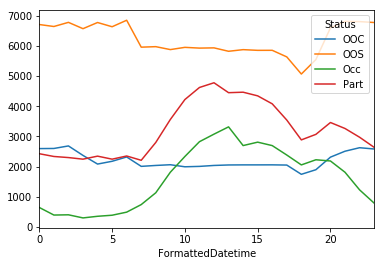

In [66]:
#let's plot the first week of charging statuses per hour

firstWeek.groupby([firstWeek.FormattedDatetime.dt.hour,'Status']).Status.count().unstack().plot()

In [67]:
firstWeek.tail()
#well it looks like there's still a bunch of NaN values we need to take care of

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
1213370,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 19:50:00,0,0,0,0
1213371,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 19:55:00,0,0,0,0
1213372,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 20:00:00,0,0,0,0
1213373,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 20:05:00,0,0,0,0
1213374,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 20:10:00,0,0,0,0


In [68]:
#here is one, for example
full_data.iloc[[1213372]]

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
1213372,NaN,NaN,NaN,NaN,0.0,0.0,2016-11-09 20:00:00,0,0,0,0


In [69]:
#let's see the comparison of the size of the full data and first week data
fullShape = full_data.shape
firstWShape = firstWeek.shape

print("Shape of full data: ",fullShape)
print("Shape of first week: ",firstWShape)
print()
print("The first week of data is %s of the total data" % (str(float(firstWShape[0])/(float(fullShape[0])))))

Shape of full data:  (17312968, 11)
Shape of first week:  (319177, 11)

The first week of data is 0.0184357182431 of the total data


In [70]:
#null values in full dataframe
full_data.isnull().sum()

ChargePointID        290605
ChargePointType        5710
Status                 5710
Address                5710
Latitude                  0
Longitude                 0
FormattedDatetime         0
OOC                       0
OOS                       0
Occ                       0
Part                      0
dtype: int64

In [71]:
fullNull = full_data.isnull().sum()
print("Even though %s values are missing,\nthat is only %s of the total data" 
      % (str(fullNull[0]),(str(float(fullNull[0])/(float(fullShape[0]))))))

Even though 290605 values are missing,
that is only 0.0167853946244 of the total data


In [72]:
#null values in first week of data
firstWeek.isnull().sum()

ChargePointID        7581
ChargePointType       191
Status                191
Address               191
Latitude                0
Longitude               0
FormattedDatetime       0
OOC                     0
OOS                     0
Occ                     0
Part                    0
dtype: int64

In [73]:
firstWnull = firstWeek.isnull().sum()
print("Even though %s values are missing in the first week,\nthat is only %s of the first week of data" 
      % (str(firstWnull[0]),(str(float(firstWnull[0])/(float(fullShape[0]))))))

Even though 7581 values are missing in the first week,
that is only 0.000437879859768 of the first week of data


In [74]:
#see all missing values in first week of data
firstWeek[firstWeek.ChargePointID.isnull()]

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
21,NaN,StandardType2,OOC,"Red Cow Luas Park and Ride, Naas Road, Dublin ...",-6.368978,53.316497,2016-11-02 06:40:00,1,0,0,0
49,NaN,StandardType2,OOS,"Town Centre Car Park, Off Main Street, Roscomm...",-8.188676,53.630905,2016-11-02 06:40:00,0,1,0,0
121,NaN,CHAdeMO,OOS,"Nissan Tralee (Randles Bros), Manor West Retai...",-9.676226,52.262744,2016-11-02 06:40:00,0,1,0,0
143,NaN,StandardType2,OOC,"Red Cow Luas Park and Ride, Naas Road, Dublin ...",-6.368978,53.316497,2016-11-02 06:45:00,1,0,0,0
171,NaN,StandardType2,OOS,"Town Centre Car Park, Off Main Street, Roscomm...",-8.188676,53.630905,2016-11-02 06:45:00,0,1,0,0
243,NaN,CHAdeMO,OOS,"Nissan Tralee (Randles Bros), Manor West Retai...",-9.676226,52.262744,2016-11-02 06:45:00,0,1,0,0
261,NaN,StandardType2,OOC,"Stillorgan Luas Park & Ride, Blackthorn Drive,...",-6.213815,53.280332,2016-11-02 06:50:00,1,0,0,0
266,NaN,StandardType2,OOC,"Red Cow Luas Park and Ride, Naas Road, Dublin ...",-6.368978,53.316497,2016-11-02 06:50:00,1,0,0,0
294,NaN,StandardType2,OOS,"Town Centre Car Park, Off Main Street, Roscomm...",-8.188676,53.630905,2016-11-02 06:50:00,0,1,0,0
364,NaN,CHAdeMO,OOS,"Nissan Tralee (Randles Bros), Manor West Retai...",-9.676226,52.262744,2016-11-02 06:50:00,0,1,0,0


In [75]:
full_data.Address.value_counts()

Copley Street, Cork City, County Cork                                                                         161613
Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin                              161264
Blanchardstown Centre, Navan Road, Clonsilla, Dublin 15, County Dublin                                        140014
Sprucefield Shopping Centre, Off Lisburn-Hillsborough Road (A1 & M1), Hillsborough, County Down, BT27 5UJ     138209
Texaco (Mace & Supermacs), N4, Ballinalack, County Westmeath                                                  125412
St. Agnes Road, Crumlin, Dublin 12, County Dublin                                                             122728
Red Cow Luas Park and Ride, Naas Road, Dublin 24, County Dublin                                               122663
West End, Banagher, County Offaly                                                                             122297
Recreation Centre Car Park, 20 Cathedral Road, Armagh, BT61 7QX 

In [76]:
#how many entries would complete data for a week for a particular location be?

print("If data was recorded at 5-minute intervals for a week,\nthere would be %s entries"
      % (str(12*24*7)))

#5-minute intervals = 12 per hour
#12 * 24 hours in a day
#multiply that by 7 days in a week

If data was recorded at 5-minute intervals for a week,
there would be 2016 entries


In [77]:
"""let's look at how many entries there are in the first week for the
top 2 most common (in the full data) addresses
"""
#most common address: 'Copley Street, Cork City, County Cork'
CopleyStMask = firstWeek.Address == 'Copley Street, Cork City, County Cork'
#print("Copley St Mask:\n",CopleyStMask.head())
CopleySt = firstWeek[CopleyStMask]
CopleySt

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
614,C5Y4R,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.466071,51.895190,2016-11-02 19:30:00,0,0,0,1
615,C63Z9,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.467683,51.895178,2016-11-02 19:30:00,0,0,0,1
784,C5Y4R,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.466071,51.895190,2016-11-02 19:35:00,0,0,0,1
785,C63Z9,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.467683,51.895178,2016-11-02 19:35:00,0,0,0,1
950,C5Y4R,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.466071,51.895190,2016-11-02 19:40:00,0,0,0,1
951,C63Z9,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.467683,51.895178,2016-11-02 19:40:00,0,0,0,1
1120,C5Y4R,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.466071,51.895190,2016-11-02 19:45:00,0,0,0,1
1121,C63Z9,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.467683,51.895178,2016-11-02 19:45:00,0,0,0,1
1280,C5Y4R,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.466071,51.895190,2016-11-02 19:50:00,0,0,0,1
1281,C63Z9,StandardType2,Part,"Copley Street, Cork City, County Cork",-8.467683,51.895178,2016-11-02 19:50:00,0,0,0,1


In [78]:
CopleySt.shape

(2187, 11)

In [79]:
#second most common address: 'Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin'
ParkPointetMask = firstWeek.Address == 'Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin'
#print("Park Pointe Mask:\n",ParkPointetMask.head())
ParkPointe = firstWeek[ParkPointetMask]
ParkPointe

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
738,C85WS,ComboCCS,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:30:00,0,0,1,0
761,C85WS,CHAdeMO,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:30:00,0,0,1,0
906,C85WS,ComboCCS,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:35:00,0,0,1,0
928,C85WS,CHAdeMO,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:35:00,0,0,1,0
1074,C85WS,ComboCCS,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:40:00,0,0,1,0
1097,C85WS,CHAdeMO,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 19:40:00,0,0,1,0
5145,C85WS,ComboCCS,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 21:50:00,0,0,1,0
5159,C85WS,CHAdeMO,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 21:50:00,0,0,1,0
5290,C85WS,ComboCCS,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 21:55:00,0,0,1,0
5304,C85WS,CHAdeMO,Occ,"Park Pointe Shopping Centre, Glenageary Road U...",-6.143881,53.282568,2016-11-02 21:55:00,0,0,1,0


In [80]:
ParkPointe.shape

(942, 11)

In [81]:
print("If there should be 2016 entries per address per week, then there should be about %s entries in the full data set per address after adding in the Available timestams"
     % (str(2016*4*12+2016*4*2)))

If there should be 2016 entries per address per week, then there should be about 112896 entries in the full data set per address after adding in the Available timestams


In [82]:
#view total entries per address
full_data.Address.value_counts()

Copley Street, Cork City, County Cork                                                                         161613
Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin                              161264
Blanchardstown Centre, Navan Road, Clonsilla, Dublin 15, County Dublin                                        140014
Sprucefield Shopping Centre, Off Lisburn-Hillsborough Road (A1 & M1), Hillsborough, County Down, BT27 5UJ     138209
Texaco (Mace & Supermacs), N4, Ballinalack, County Westmeath                                                  125412
St. Agnes Road, Crumlin, Dublin 12, County Dublin                                                             122728
Red Cow Luas Park and Ride, Naas Road, Dublin 24, County Dublin                                               122663
West End, Banagher, County Offaly                                                                             122297
Recreation Centre Car Park, 20 Cathedral Road, Armagh, BT61 7QX 

In [83]:
#make list of total entries
totalEntries = full_data['Address'].value_counts().tolist()
totalEntries

[161613,
 161264,
 140014,
 138209,
 125412,
 122728,
 122663,
 122297,
 121966,
 116013,
 115576,
 113702,
 112780,
 112605,
 112392,
 108503,
 100911,
 100344,
 100196,
 99051,
 95755,
 94076,
 93032,
 92370,
 91992,
 91534,
 90145,
 89663,
 81121,
 80851,
 80692,
 80614,
 80379,
 79680,
 79149,
 76343,
 76108,
 75867,
 75726,
 75314,
 74968,
 74287,
 74241,
 73444,
 73050,
 72095,
 71852,
 71761,
 69949,
 69730,
 69516,
 67915,
 67101,
 66765,
 66589,
 66413,
 65662,
 64491,
 64154,
 64149,
 64068,
 63573,
 63541,
 63031,
 62346,
 61968,
 61016,
 59775,
 59277,
 59219,
 58970,
 58658,
 58570,
 58109,
 56346,
 56113,
 56074,
 55230,
 55144,
 54428,
 54330,
 54037,
 53743,
 53364,
 52801,
 52547,
 51665,
 51620,
 51524,
 51426,
 51288,
 51223,
 50825,
 50464,
 50118,
 49898,
 49465,
 49381,
 48967,
 48900,
 48819,
 48766,
 48104,
 47748,
 47397,
 47144,
 47095,
 47084,
 46570,
 46467,
 46342,
 46247,
 46212,
 45563,
 45382,
 45220,
 45169,
 45135,
 45002,
 44865,
 44805,
 43623,
 4342

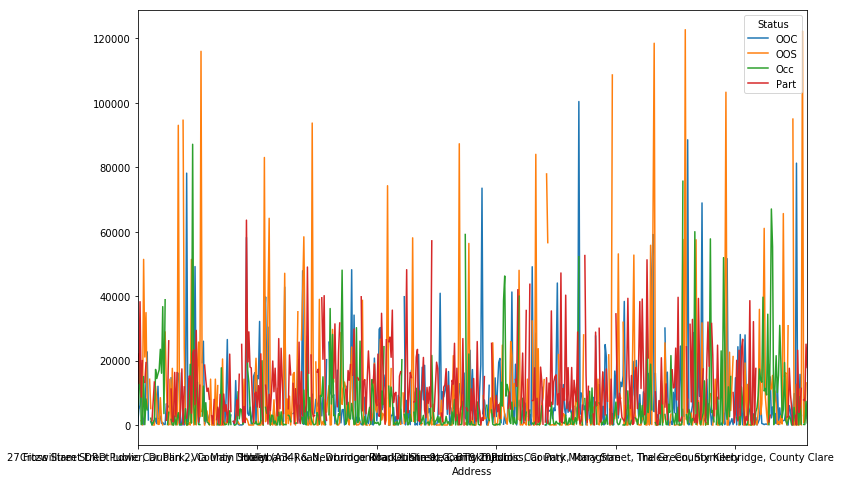

In [84]:
#let's plot the counts of various statuses per address
full_data.groupby('Address')['Status'].value_counts().unstack().plot(figsize=(12,8))

In [85]:
#make list of all addresses
totalAddresses = full_data['Address'].value_counts().index.tolist()
totalAddresses

['Copley Street, Cork City, County Cork',
 'Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin',
 'Blanchardstown Centre, Navan Road, Clonsilla, Dublin 15, County Dublin',
 'Sprucefield Shopping Centre, Off Lisburn-Hillsborough Road (A1 & M1), Hillsborough, County Down, BT27 5UJ',
 'Texaco (Mace & Supermacs), N4, Ballinalack, County Westmeath',
 'St. Agnes Road, Crumlin, Dublin 12, County Dublin',
 'Red Cow Luas Park and Ride, Naas Road, Dublin 24, County Dublin',
 'West End, Banagher, County Offaly',
 'Recreation Centre Car Park, 20 Cathedral Road, Armagh, BT61 7QX',
 'Bus Station Car Park, Donore Road, Drogheda, County Louth',
 'DRD Car Park, Brooke Street, Omagh, BT78 5HD',
 'Supervalu Car Park, Off Green Street, Roscrea, County Tipperary',
 'Navenny Street, Ballybofey, County Donegal',
 'Public Car Park, Kennedy Street, Carlow Town, County Carlow',
 'Barbican Centra, Dromore Road (A1), Banbridge, BT32 4ET',
 'Downshire Place, Banbridge, BT32 3DF',
 "St

In [86]:
full_data.groupby('Address')['Status'].value_counts()

Address                                                                                Status
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                                   Part       22086
                                                                                       Occ         2781
                                                                                       OOC            4
29 Adelaide Road, Dublin 2, County Dublin                                              Part       12887
                                                                                       Occ         8510
                                                                                       OOS         7935
                                                                                       OOC         4818
51 South Mall, Cork City, County Cork                                                  Part       38291
                                                                          

In [87]:
addressAndNums = full_data.Address.value_counts()
print(type(addressAndNums))
print()
print(addressAndNums)

<class 'pandas.core.series.Series'>

Copley Street, Cork City, County Cork                                                                         161613
Park Pointe Shopping Centre, Glenageary Road Upper, Dun Laoghaire, County Dublin                              161264
Blanchardstown Centre, Navan Road, Clonsilla, Dublin 15, County Dublin                                        140014
Sprucefield Shopping Centre, Off Lisburn-Hillsborough Road (A1 & M1), Hillsborough, County Down, BT27 5UJ     138209
Texaco (Mace & Supermacs), N4, Ballinalack, County Westmeath                                                  125412
St. Agnes Road, Crumlin, Dublin 12, County Dublin                                                             122728
Red Cow Luas Park and Ride, Naas Road, Dublin 24, County Dublin                                               122663
West End, Banagher, County Offaly                                                                             122297
Recreation Centre Car Park,

In [88]:
#how many unique addresses are there total?
full_data.Address.nunique()

561

In [89]:
valueCounts = full_data.Address.value_counts()
#make list of addresses and total entries
addsAndNumsLst = zip(valueCounts,valueCounts.index)

In [90]:
"""I want to take a look at the OOC and OOS value_counts
in the full data set because I want to be working with a chunk of the
full data set that has minimal OOC and OOS (out of contact and out of
service) values, and newData_aboveThresh doesn't tackle that
"""
#full_data.groupby('Address')['OOC','OOS','Occ','Part'].count()

#OOC
OOCmask = full_data.OOC == 1
OOC = full_data[OOCmask]

#OOS
OOSmask = full_data.OOS == 1
OOS = full_data[OOSmask]

In [91]:
print("OOC shape: ", OOC.shape)
print("OOS shape: ", OOS.shape)

OOC shape:  (4226165, 11)
OOS shape:  (4900677, 11)


In [92]:
#of all the addresses, which have the least OOC and OOS?
OOClst = full_data.groupby('Address')['OOC'].sum()
print(OOClst)

Address
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                                                4
29 Adelaide Road, Dublin 2, County Dublin                                                        4818
51 South Mall, Cork City, County Cork                                                            6134
9-12 Union Place, Sligo Town, County Sligo                                                      11372
95 Glanmire Road, Cork City, County Cork                                                         2749
Abbey Court Hotel, Dublin Road, Nenagh, County Tipperary                                          126
Abbey Street, Wexford, County Wexford                                                            3849
Adelaide Street, Belfast, BT2 8GB                                                               13348
Agnew Street, Larne, BT40 1RF                                                                   22709
Albert Street Car Park, Off Main Street & Strabane Road, Castlederg, Strab

In [93]:
OOSlst = full_data.groupby('Address')['OOS'].sum()
print(OOSlst)

Address
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                                                 0
29 Adelaide Road, Dublin 2, County Dublin                                                         7935
51 South Mall, Cork City, County Cork                                                                0
9-12 Union Place, Sligo Town, County Sligo                                                        1397
95 Glanmire Road, Cork City, County Cork                                                             2
Abbey Court Hotel, Dublin Road, Nenagh, County Tipperary                                         51422
Abbey Street, Wexford, County Wexford                                                            21114
Adelaide Street, Belfast, BT2 8GB                                                                34902
Agnew Street, Larne, BT40 1RF                                                                     5341
Albert Street Car Park, Off Main Street & Strabane Road, Castlede

In [94]:
#make combined list of OOC and OOS scores for all addresses
totalsOOCOOS = [x + y for x, y in zip(OOClst, OOSlst)]

In [95]:
totalsOOCOOS

[4,
 12753,
 6134,
 12769,
 2751,
 51548,
 24963,
 48250,
 28050,
 1577,
 14221,
 6128,
 93,
 723,
 552,
 14117,
 8031,
 12245,
 2011,
 11294,
 1856,
 830,
 222,
 29022,
 19347,
 8515,
 5646,
 14243,
 14708,
 23097,
 149,
 7692,
 12382,
 4701,
 108566,
 17691,
 34,
 26,
 98273,
 23969,
 1853,
 78197,
 1060,
 15053,
 6666,
 69974,
 30549,
 1174,
 66926,
 8513,
 26485,
 26029,
 5599,
 116013,
 23400,
 32767,
 226,
 3200,
 5786,
 2634,
 3046,
 14243,
 1480,
 531,
 55,
 14243,
 6191,
 12245,
 4995,
 2572,
 186,
 22238,
 7413,
 978,
 8755,
 28557,
 848,
 1079,
 3101,
 8402,
 1116,
 29,
 30268,
 2785,
 1203,
 315,
 52,
 23,
 678,
 15145,
 2907,
 60345,
 5037,
 2979,
 5564,
 278,
 3234,
 15179,
 28557,
 21124,
 23855,
 14385,
 32159,
 544,
 2539,
 1794,
 115576,
 40802,
 15064,
 66806,
 68565,
 47,
 2557,
 618,
 13773,
 263,
 100,
 16789,
 8674,
 284,
 3180,
 1264,
 15340,
 89927,
 2869,
 8102,
 2598,
 10974,
 1292,
 4449,
 19347,
 20167,
 3892,
 12998,
 55513,
 1573,
 683,
 30497,
 88681,
 5

In [96]:
#what are the 10 smallest values?
nsmallest(10, totalsOOCOOS) #the 0, 37, 87, 211, 234, 261, 317, 329, 382, and 487 indexes

[0, 0, 2, 2, 4, 12, 23, 24, 26, 26]

In [97]:
list(enumerate(totalsOOCOOS))

[(0, 4),
 (1, 12753),
 (2, 6134),
 (3, 12769),
 (4, 2751),
 (5, 51548),
 (6, 24963),
 (7, 48250),
 (8, 28050),
 (9, 1577),
 (10, 14221),
 (11, 6128),
 (12, 93),
 (13, 723),
 (14, 552),
 (15, 14117),
 (16, 8031),
 (17, 12245),
 (18, 2011),
 (19, 11294),
 (20, 1856),
 (21, 830),
 (22, 222),
 (23, 29022),
 (24, 19347),
 (25, 8515),
 (26, 5646),
 (27, 14243),
 (28, 14708),
 (29, 23097),
 (30, 149),
 (31, 7692),
 (32, 12382),
 (33, 4701),
 (34, 108566),
 (35, 17691),
 (36, 34),
 (37, 26),
 (38, 98273),
 (39, 23969),
 (40, 1853),
 (41, 78197),
 (42, 1060),
 (43, 15053),
 (44, 6666),
 (45, 69974),
 (46, 30549),
 (47, 1174),
 (48, 66926),
 (49, 8513),
 (50, 26485),
 (51, 26029),
 (52, 5599),
 (53, 116013),
 (54, 23400),
 (55, 32767),
 (56, 226),
 (57, 3200),
 (58, 5786),
 (59, 2634),
 (60, 3046),
 (61, 14243),
 (62, 1480),
 (63, 531),
 (64, 55),
 (65, 14243),
 (66, 6191),
 (67, 12245),
 (68, 4995),
 (69, 2572),
 (70, 186),
 (71, 22238),
 (72, 7413),
 (73, 978),
 (74, 8755),
 (75, 28557),
 (76,

In [98]:
#let's make a new list with the 10 addresses with the smallest OOC/OOS sums
addresses = []
addresses.append(OOClst.index[0])
addresses.append(OOClst.index[37])
addresses.append(OOClst.index[87])
addresses.append(OOClst.index[211])
addresses.append(OOClst.index[234])
addresses.append(OOClst.index[261])
addresses.append(OOClst.index[317])
addresses.append(OOClst.index[329])
addresses.append(OOClst.index[382])
addresses.append(OOClst.index[487])
print(addresses)

['27 Fitzwilliam Street Lower, Dublin 2, County Dublin', 'Barrack Street, Castlerea, County Roscommon', 'Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin', 'Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin', 'Irish Rail, Lord Edward Street, Sligo Town, County Sligo', 'Lesure Centre Car Park, Off James Street, Westport, County Mayo', "Merchant's Quay, Limerick City, County Limerick", "Moy Court, Off Bachelor's Wal20170901na, County Mayo", 'Public Car ParCP:SC18 Road, Galway City, County Galway', 'Tesco, Airside Retail Park, Swords, County Dublin']


In [99]:
len(addresses) #checking our list has the correct number of addresses

10

In [100]:
print("The ten charge point stations I am most interested in are:")
print()
for x in addresses:
    print(x)

The ten charge point stations I am most interested in are:

27 Fitzwilliam Street Lower, Dublin 2, County Dublin
Barrack Street, Castlerea, County Roscommon
Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin
Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin
Irish Rail, Lord Edward Street, Sligo Town, County Sligo
Lesure Centre Car Park, Off James Street, Westport, County Mayo
Merchant's Quay, Limerick City, County Limerick
Moy Court, Off Bachelor's Wal20170901na, County Mayo
Public Car ParCP:SC18 Road, Galway City, County Galway
Tesco, Airside Retail Park, Swords, County Dublin


In [101]:
#let's make a new dataframe with just those 10 addresses
top10CPdata = full_data[full_data['Address'].isin(addresses)]

In [102]:
top10CPdata.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
17,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0,0,0,1
139,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0,0,0,1
262,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0,0,0,1
382,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0,0,0,1
503,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0,0,0,1


In [103]:
#now we need to reset the index
top10CPdata.reset_index(drop=True)

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0,0,0,1
1,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0,0,0,1
2,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0,0,0,1
3,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0,0,0,1
4,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0,0,0,1
5,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 19:30:00,0,0,0,1
6,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 19:35:00,0,0,0,1
7,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 19:40:00,0,0,0,1
8,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 19:45:00,0,0,0,1
9,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 19:50:00,0,0,0,1


In [104]:
#how many entires do we have for each address?
top10dataCounts = top10CPdata.groupby('Address')['ChargePointID'].count()
top10dataCounts

Address
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                      24871
Barrack Street, Castlerea, County Roscommon                               17848
Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin      29585
Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin    32993
Irish Rail, Lord Edward Street, Sligo Town, County Sligo                  24925
Lesure Centre Car Park, Off James Street, Westport, County Mayo            3463
Merchant's Quay, Limerick City, County Limerick                           12524
Moy Court, Off Bachelor's Wal20170901na, County Mayo                          2
Public Car ParCP:SC18 Road, Galway City, County Galway                        2
Tesco, Airside Retail Park, Swords, County Dublin                             5
Name: ChargePointID, dtype: int64

In [105]:
#four of the addresses don't have much data at all, so let's get rid of those
addresses = addresses[:-3]
addresses

['27 Fitzwilliam Street Lower, Dublin 2, County Dublin',
 'Barrack Street, Castlerea, County Roscommon',
 'Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin',
 'Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin',
 'Irish Rail, Lord Edward Street, Sligo Town, County Sligo',
 'Lesure Centre Car Park, Off James Street, Westport, County Mayo',
 "Merchant's Quay, Limerick City, County Limerick"]

In [106]:
del addresses[5]
addresses

['27 Fitzwilliam Street Lower, Dublin 2, County Dublin',
 'Barrack Street, Castlerea, County Roscommon',
 'Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin',
 'Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin',
 'Irish Rail, Lord Edward Street, Sligo Town, County Sligo',
 "Merchant's Quay, Limerick City, County Limerick"]

In [107]:
#let's update the df to have the 6 addresses we want
top6CPdata = full_data[full_data['Address'].isin(addresses)]
top6dataCounts = top6CPdata.groupby('Address')['ChargePointID'].count()
top6dataCounts

Address
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                      24871
Barrack Street, Castlerea, County Roscommon                               17848
Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin      29585
Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin    32993
Irish Rail, Lord Edward Street, Sligo Town, County Sligo                  24925
Merchant's Quay, Limerick City, County Limerick                           12524
Name: ChargePointID, dtype: int64

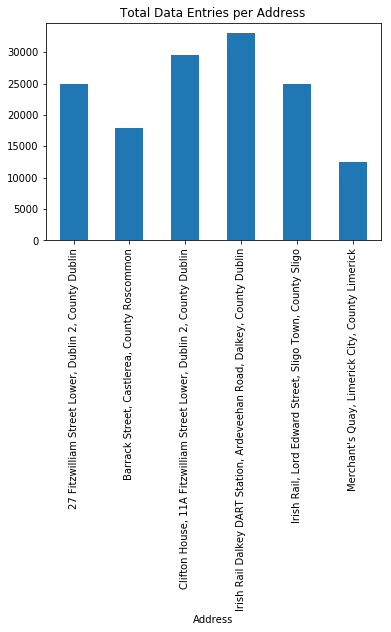

In [108]:
#let's graph those numbers
top6dataCounts.plot(kind='bar',title='Total Data Entries per Address')
sns.mpl.pyplot.xlabel ='Address'
sns.mpl.pyplot.ylabel = 'Data Entries'

In [109]:
#let's check for null values
top6CPdata.isnull().sum() #sweet!

ChargePointID        0
ChargePointType      0
Status               0
Address              0
Latitude             0
Longitude            0
FormattedDatetime    0
OOC                  0
OOS                  0
Occ                  0
Part                 0
dtype: int64

In [110]:
#let's make each address it's own dataframe
fitzMask = top6CPdata.Address == '27 Fitzwilliam Street Lower, Dublin 2, County Dublin'
fitz = top6CPdata[fitzMask]
barrackMask = top6CPdata.Address == 'Barrack Street, Castlerea, County Roscommon'
barrack = top6CPdata[barrackMask]
cliftonMask = top6CPdata.Address == 'Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin'
clifton = top6CPdata[cliftonMask]
irishONEMask = top6CPdata.Address == 'Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin'
irishONE = top6CPdata[irishONEMask]
irishTWOMask = top6CPdata.Address == 'Irish Rail, Lord Edward Street, Sligo Town, County Sligo'
irishTWO = top6CPdata[irishTWOMask]
merchantMask = top6CPdata.Address == "Merchant's Quay, Limerick City, County Limerick"
merchant = top6CPdata[merchantMask]

In [111]:
top6CPdata.groupby('Address')['OOC'].value_counts()

Address                                                                 OOC
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                    0      24867
                                                                        1          4
Barrack Street, Castlerea, County Roscommon                             0      17822
                                                                        1         26
Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin    0      29562
                                                                        1         23
Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin  0      32968
                                                                        1         25
Irish Rail, Lord Edward Street, Sligo Town, County Sligo                0      24913
                                                                        1         12
Merchant's Quay, Limerick City, County Limerick                         0 

In [112]:
top6CPdata.groupby('Address')['OOS'].value_counts()

Address                                                                 OOS
27 Fitzwilliam Street Lower, Dublin 2, County Dublin                    0      24871
Barrack Street, Castlerea, County Roscommon                             0      17848
Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin    0      29585
Irish Rail Dalkey DART Station, Ardeveehan Road, Dalkey, County Dublin  0      32992
                                                                        1          1
Irish Rail, Lord Edward Street, Sligo Town, County Sligo                0      24925
Merchant's Quay, Limerick City, County Limerick                         0      12524
Name: OOS, dtype: int64

In [113]:
print("Shape of fitz: ", fitz.shape)
print("Shape of barrack: ", barrack.shape)
print("Shape of clifton: ", clifton.shape)
print("Shape of irishONE: ", irishONE.shape)
print("Shape of irishTWO: ", irishTWO.shape)
print("Shape of merchant: ", merchant.shape)

Shape of fitz:  (24871, 11)
Shape of barrack:  (17848, 11)
Shape of clifton:  (29585, 11)
Shape of irishONE:  (32993, 11)
Shape of irishTWO:  (24925, 11)
Shape of merchant:  (12524, 11)


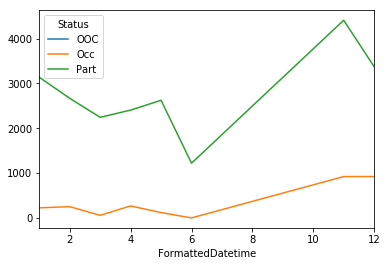

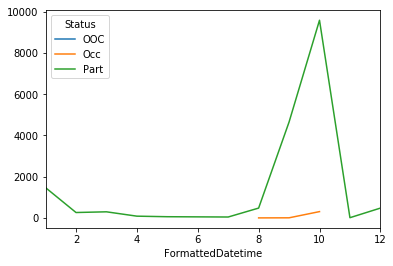

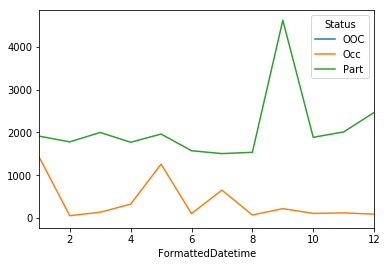

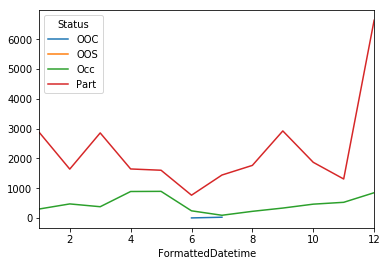

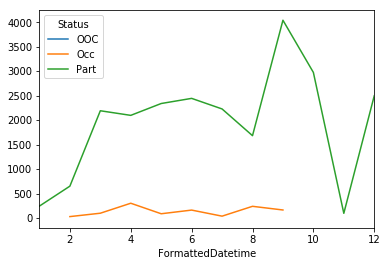

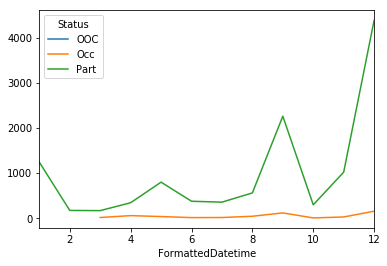

In [114]:
#let's view the status patterns in each

sixers = [fitz, barrack, clifton, irishONE, irishTWO, merchant]
for x in sixers:
    x.groupby([x.FormattedDatetime.dt.month,'Status']).Status.count().unstack().plot()

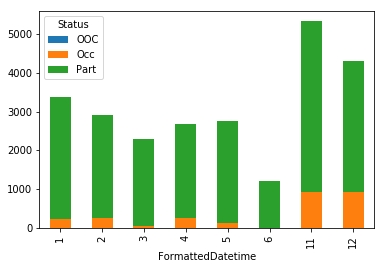

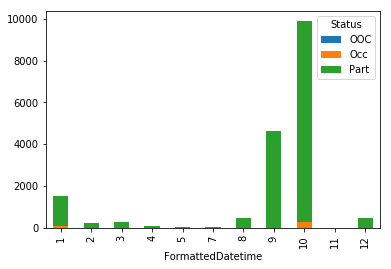

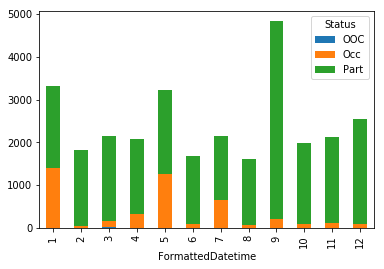

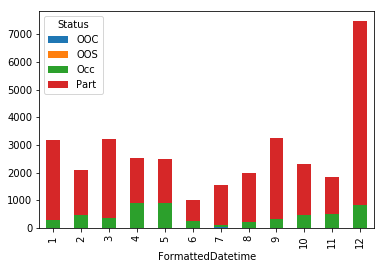

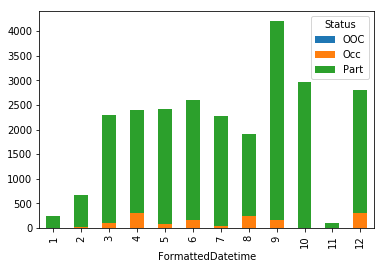

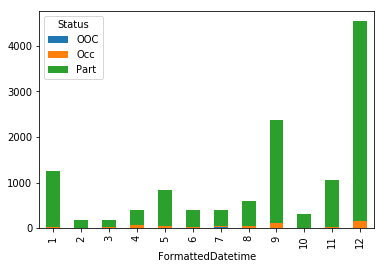

In [115]:
#let's view a stacked bar version too

for x in sixers:
    x.groupby([x.FormattedDatetime.dt.month,'Status']).Status.count().unstack().plot.bar(stacked=True)

In [116]:
"""I am going to choose a single charge point to work with.
Based on the stacked bar plot, which gives me a good picture of the status chaging over time,
I think it makes the most sense to choose a charge point with consistent use.
"""
print("I choose clifton: ", clifton.Address.unique())

I choose clifton:  ['Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin']


In [117]:
#after exploring clifton, I'm going to add in the omitted entries that represent an 'Available' status
clifton.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
17,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0,0,0,1
139,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0,0,0,1
262,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0,0,0,1
382,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0,0,0,1
503,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0,0,0,1


In [118]:
clifton.shape

(29585, 11)

In [119]:
clifton.dtypes

ChargePointID                object
ChargePointType              object
Status                       object
Address                      object
Latitude                    float64
Longitude                   float64
FormattedDatetime    datetime64[ns]
OOC                           int64
OOS                           int64
Occ                           int64
Part                          int64
dtype: object

In [120]:
clifton.Status.value_counts()

Part    25024
Occ      4538
OOC        23
Name: Status, dtype: int64

In [121]:
clifton.ChargePointID.value_counts()

C3RQP-A/B    29585
Name: ChargePointID, dtype: int64

In [122]:
clifton.ChargePointType.value_counts()

StandardType2    29585
Name: ChargePointType, dtype: int64

In [123]:
clifton.FormattedDatetime.max()

Timestamp('2017-12-31 15:21:00')

In [124]:
clifton.Latitude.value_counts()

-6.248843    17052
-6.248054    12533
Name: Latitude, dtype: int64

In [125]:
clifton.Longitude.value_counts()

53.337122    17052
53.338006    12533
Name: Longitude, dtype: int64

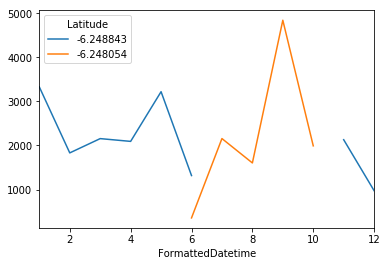

In [126]:
"""based on the Latitude and Longitude value_counts,
it looks like the charge point was moved to a nearby location.
let's find out when it moved so we can input the correct
values with the Available data."""

clifton.groupby([clifton.FormattedDatetime.dt.month,'Latitude']).Latitude.count().unstack().plot()

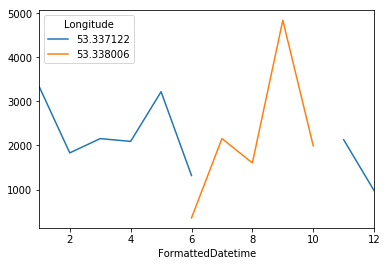

In [127]:
clifton.groupby([clifton.FormattedDatetime.dt.month,'Longitude']).Longitude.count().unstack().plot()

In [128]:
"""looks like it was at the beginning of june.
and it tells me which latitude was first. let's check"""

print(clifton.iloc[17051])
print()
print("It actually moved on: ",clifton.iloc[17052][6])
print()
print(clifton.iloc[17052])

ChargePointID                                                C3RQP-A/B
ChargePointType                                          StandardType2
Status                                                            Part
Address              Clifton House, 11A Fitzwilliam Street Lower, D...
Latitude                                                      -6.24884
Longitude                                                      53.3371
FormattedDatetime                                  2017-06-21 12:30:00
OOC                                                                  0
OOS                                                                  0
Occ                                                                  0
Part                                                                 1
Name: 771461, dtype: object

It actually moved on:  2017-06-23 10:22:00

ChargePointID                                                C3RQP-A/B
ChargePointType                                          StandardType2
Stat

In [129]:
#our start time
clifton.FormattedDatetime.min()

Timestamp('2016-11-02 06:40:00')

In [130]:
#let's test out Timedelta for our purposes
timeTest = pd.to_datetime('2016-11-02 06:40:00')
print(timeTest)

2016-11-02 06:40:00


In [131]:
print(pd.to_datetime(timeTest) + pd.Timedelta(minutes=5))
print("Perfect! It added 5 minutes to our timeTest")

2016-11-02 06:45:00
Perfect! It added 5 minutes to our timeTest


In [132]:
#creating a list of 5-minute interval timestamps with Status of all equal to 'A' for available
#same format as our previous dataframes

cliftonAVAIL = []
current = []
start = '2016-11-02 06:40:00'
time = pd.to_datetime(start)
#count = 0
while time < pd.to_datetime('2018-01-01 00:00:00'):
#while count < 5:
    current.append('C3RQP-A/B') #ChargePointID
    current.append('StandardType2') #ChargePointType
    current.append('A') #Status = available
    current.append('Clifton House, 11A Fitzwilliam Street Lower, Dublin 2, County Dublin') #Address
    if time < pd.to_datetime('2017-06-23 10:22:00'): #before charge point is moved
        current.append(float(-6.248843)) #Latitude
        current.append(float(53.337122)) #Longitude
    else: #after charge point is moved
        current.append(float(-6.248054)) #Latitude
        current.append(float(53.338006)) #Longitude 
    current.append(pd.to_datetime(time)) #Datetime
    current.append(0) #OOC
    current.append(0) #OOS
    current.append(0) #Occ
    current.append(0) #Part
    cliftonAVAIL.append(current)
    current = []
    time = pd.to_datetime(time) + pd.Timedelta(minutes=5)
    #count += 1

print(current)

[]


In [133]:
#turn list into df
cliftonAVAIL = pd.DataFrame(cliftonAVAIL, columns=['ChargePointID',
                                                         'ChargePointType',
                                                         'Status',
                                                         'Address',
                                                         'Latitude',
                                                         'Longitude',
                                                         'FormattedDatetime',
                                                         'OOC',
                                                         'OOS',
                                                         'Occ',
                                                         'Part'])

In [134]:
cliftonAVAIL.shape #great, this matches my estimate from before of the count including Availabe

(122320, 11)

In [135]:
cliftonAVAIL.dtypes

ChargePointID                object
ChargePointType              object
Status                       object
Address                      object
Latitude                    float64
Longitude                   float64
FormattedDatetime    datetime64[ns]
OOC                           int64
OOS                           int64
Occ                           int64
Part                          int64
dtype: object

In [136]:
cliftonAVAIL.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0,0,0,0
1,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0,0,0,0
2,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0,0,0,0
3,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0,0,0,0
4,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0,0,0,0


In [137]:
#check that the Datetime is within our bounding times
print("cliftonAVAIL starts: ", cliftonAVAIL.FormattedDatetime.min())
print("cliftonAVAIL ends: ", cliftonAVAIL.FormattedDatetime.max())

cliftonAVAIL starts:  2016-11-02 06:40:00
cliftonAVAIL ends:  2017-12-31 23:55:00


In [138]:
#let's make sure that the types of the two dfs are the same before joining them
print('cliftonAVAIL types:\n',cliftonAVAIL.dtypes)
print()
print('clifton types:\n',clifton.dtypes)

cliftonAVAIL types:
 ChargePointID                object
ChargePointType              object
Status                       object
Address                      object
Latitude                    float64
Longitude                   float64
FormattedDatetime    datetime64[ns]
OOC                           int64
OOS                           int64
Occ                           int64
Part                          int64
dtype: object

clifton types:
 ChargePointID                object
ChargePointType              object
Status                       object
Address                      object
Latitude                    float64
Longitude                   float64
FormattedDatetime    datetime64[ns]
OOC                           int64
OOS                           int64
Occ                           int64
Part                          int64
dtype: object


In [139]:
"""I was getting an error when trying to update cliftonAVAIL with clifton,
so I reset the index of clifton, which fixed the problem"""
#cliftonAVAIL = cliftonAVAIL.reset_index()
clifton = clifton.reset_index()

In [140]:
#finally, let's update to have a full df of values
cliftonAVAIL.update(clifton)

In [141]:
cliftonAVAIL.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0.0,0.0,0.0,1.0
1,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0.0,0.0,0.0,1.0
2,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0.0,0.0,0.0,1.0
3,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0.0,0.0,0.0,1.0
4,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0.0,0.0,0.0,1.0


In [142]:
cliftonAVAIL.shape #awesome, it's the same shape as cliftonAVAIL was before

(122320, 11)

In [143]:
cliftonAVAIL.Status.value_counts()

A       92735
Part    25024
Occ      4538
OOC        23
Name: Status, dtype: int64

In [144]:
cliftonAVAIL.tail()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
122315,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:35:00,0.0,0.0,0.0,0.0
122316,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:40:00,0.0,0.0,0.0,0.0
122317,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:45:00,0.0,0.0,0.0,0.0
122318,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:50:00,0.0,0.0,0.0,0.0
122319,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:55:00,0.0,0.0,0.0,0.0


Well, something funky happened with the Longitude (bottom graph), but it's totally usable for now


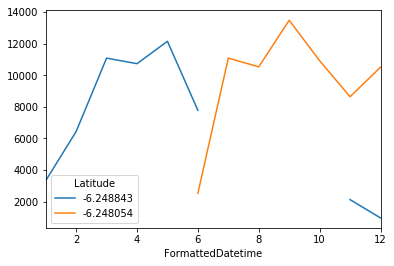

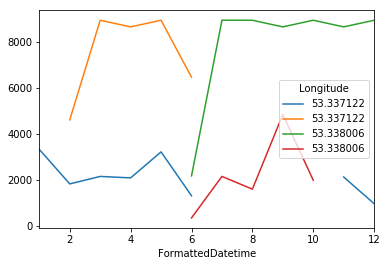

In [145]:
#let's make sure the latitude and longitude were put in accordingly
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.month,'Latitude']).Latitude.count().unstack().plot()
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.month,'Longitude']).Longitude.count().unstack().plot()
print("Well, something funky happened with the Longitude (bottom graph), but it's totally usable for now")

Now we can see all of the status data per month


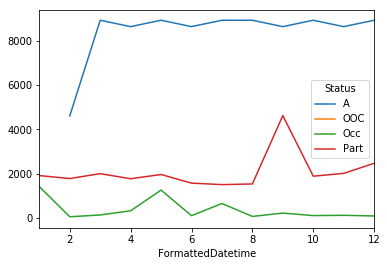

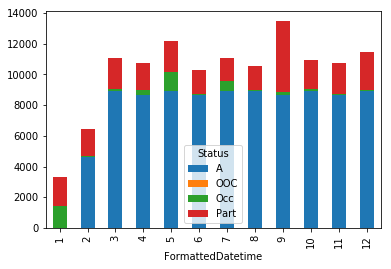

In [146]:
print("Now we can see all of the status data per month")
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.month,'Status']).Status.count().unstack().plot()
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.month,'Status']).Status.count().unstack().plot.bar(stacked=True)

and statuses by hour...


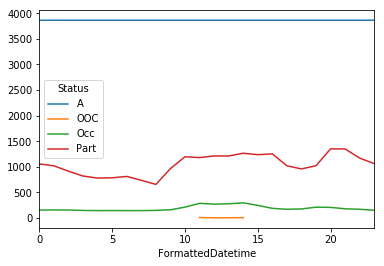

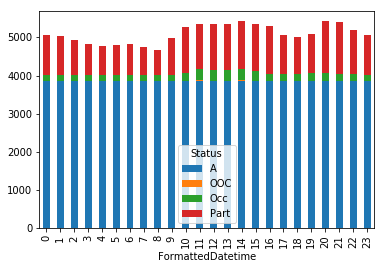

In [147]:
print('and statuses by hour...')
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.hour,'Status']).Status.count().unstack().plot()
cliftonAVAIL.groupby([cliftonAVAIL.FormattedDatetime.dt.hour,'Status']).Status.count().unstack().plot.bar(stacked=True)

In [148]:
cliftonAVAIL.head()

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:40:00,0.0,0.0,0.0,1.0
1,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:45:00,0.0,0.0,0.0,1.0
2,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:50:00,0.0,0.0,0.0,1.0
3,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 06:55:00,0.0,0.0,0.0,1.0
4,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2016-11-02 07:00:00,0.0,0.0,0.0,1.0


In [149]:
cliftonAVAIL['Status_Number'] = (cliftonAVAIL.Status != 'A').astype(int)
cliftonAVAIL.Status_Number.value_counts()

0    92735
1    29585
Name: Status_Number, dtype: int64

In [150]:
print("The Status_Number presents whether a charge point is Available 0 or Unavailable 1")

The Status_Number presents whether a charge point is Available 0 or Unavailable 1


In [151]:
cliftonAVAIL['Hour'] = cliftonAVAIL.FormattedDatetime.dt.hour
cliftonAVAIL['Minute'] = cliftonAVAIL.FormattedDatetime.dt.minute

#assign 5-minute interval Period (0-287)
cliftonAVAIL['Period'] = cliftonAVAIL.apply(lambda row: (12*row['Minute']/60) + 12*row['Hour'],
                                            axis=1)

In [152]:
cliftonAVAIL.tail(3)

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part,Status_Number,Hour,Minute,Period
122317,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:45:00,0.0,0.0,0.0,0.0,0,23,45,285
122318,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:50:00,0.0,0.0,0.0,0.0,0,23,50,286
122319,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-12-31 23:55:00,0.0,0.0,0.0,0.0,0,23,55,287


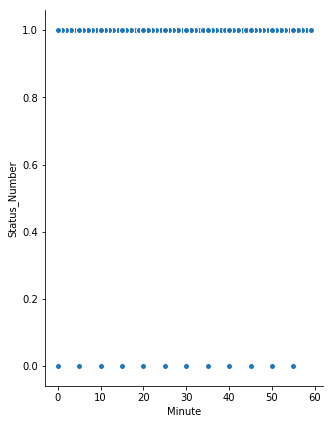

In [153]:
sns.pairplot(cliftonAVAIL,
            x_vars='Minute',
            y_vars='Status_Number', size=6, aspect=0.8)

In [154]:
"""as a baseline, I'm going to run linear regression and get the accuracy and RMSE.
I will use that and the Null accuracy to compare other models"""

#set up linear regression
feature_cols_LinReg = ['Minute']
X_LinReg = cliftonAVAIL[feature_cols_LinReg]
y_LinReg = cliftonAVAIL.Status_Number
linreg = LinearRegression()

#run linear regression
linreg.fit(X_LinReg, y_LinReg)
LinReg_outcome_pred = linreg.predict(X_LinReg)

In [155]:
LinReg_outcome_pred

array([ 0.24753523,  0.2498365 ,  0.25213776, ...,  0.2498365 ,
        0.25213776,  0.25443903])

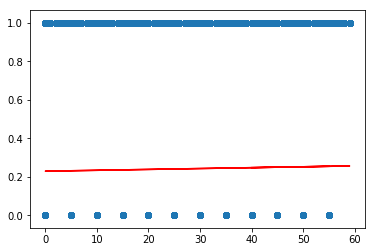

In [156]:
#scatter plot that includes the regression line
plt.scatter(cliftonAVAIL.Minute, cliftonAVAIL.Status_Number)
plt.plot(cliftonAVAIL.Minute, LinReg_outcome_pred, color='red')

In [157]:
np.where(LinReg_outcome_pred >= 0.5, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [158]:
np.set_printoptions(threshold=np.inf)
#np.set_printoptions(threshold=1000)

In [159]:
LinReg_outcome_pred

array([ 0.24753523,  0.2498365 ,  0.25213776,  0.25443903,  0.22912511,
        0.2429327 ,  0.24523397,  0.24753523,  0.2498365 ,  0.25213776,
        0.25443903,  0.22912511,  0.23142638,  0.23372764,  0.23602891,
        0.23833017,  0.24063144,  0.2429327 ,  0.24523397,  0.24753523,
        0.2498365 ,  0.25213776,  0.25443903,  0.22912511,  0.23142638,
        0.23372764,  0.23602891,  0.23833017,  0.24063144,  0.2429327 ,
        0.24523397,  0.24753523,  0.2498365 ,  0.25213776,  0.25443903,
        0.22912511,  0.23142638,  0.23372764,  0.23602891,  0.23833017,
        0.24063144,  0.2429327 ,  0.24523397,  0.24753523,  0.2498365 ,
        0.25213776,  0.25443903,  0.22912511,  0.23142638,  0.23372764,
        0.23602891,  0.23833017,  0.24063144,  0.2429327 ,  0.24523397,
        0.24753523,  0.2498365 ,  0.25213776,  0.25443903,  0.22912511,
        0.23142638,  0.23372764,  0.23602891,  0.23833017,  0.25213776,
        0.25443903,  0.22912511,  0.23142638,  0.23372764,  0.23

In [160]:
print(min(LinReg_outcome_pred))
print(max(LinReg_outcome_pred))

0.229125112562
0.256280040148


In [161]:
#i chose an arbitrary threshold close to the middle of the predictions
LinReg_outcome_pred_class = np.where(LinReg_outcome_pred >= 0.24, 1, 0)

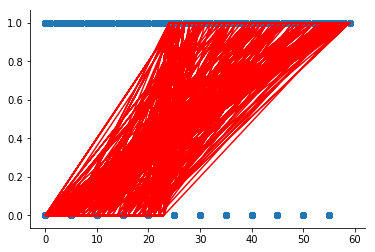

In [162]:
#plot the class predictions
plt.scatter(cliftonAVAIL.Minute, cliftonAVAIL.Status_Number)
plt.plot(cliftonAVAIL.Minute, LinReg_outcome_pred_class, color='red')
sns.despine();

In [163]:
#add linear regression predicted class to dataframe
cliftonAVAIL['LinReg_Pred_Class'] = LinReg_outcome_pred_class

#sort dataframe by Hour so that the line plot makes sense
cliftonAVAIL.sort_values('Minute', inplace=True)

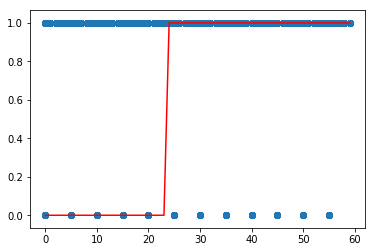

In [164]:
#plot the class predictions again
plt.scatter(cliftonAVAIL.Minute, cliftonAVAIL.Status_Number)
plt.plot(cliftonAVAIL.Minute, cliftonAVAIL.LinReg_Pred_Class, color='red')

In [165]:
print("Linear Regression baseline RMSE:", np.sqrt(metrics.mean_squared_error(y_LinReg, LinReg_outcome_pred)))
print("Linear Regression baseline accuracy:", metrics.accuracy_score(y_LinReg, LinReg_outcome_pred.round()))

Linear Regression baseline RMSE: 0.428139473394
Linear Regression baseline accuracy: 0.75813440157


In [166]:
"""great, now let's split test/train data and see if we can improve those scores with
logistic regression"""

#let's find the index of where to split the data (between 2016-11-01 and 2017-10-31)
cliftonAVAIL[cliftonAVAIL['FormattedDatetime'] < '2017-11-01 00:00:00']

,ChargePointID,ChargePointType,Status,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part,Status_Number,Hour,Minute,Period,LinReg_Pred_Class
84664,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-08-23 06:00:00,0.0,0.0,0.0,0.0,0,6,0,72,0
96976,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-10-05 00:00:00,0.0,0.0,0.0,0.0,0,0,0,0,0
56956,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-19 01:00:00,0.0,0.0,0.0,0.0,0,1,0,12,0
13186,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-18 19:00:00,0.0,0.0,0.0,1.0,1,19,0,228,0
56944,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-19 00:00:00,0.0,0.0,0.0,0.0,0,0,0,0,0
56932,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-18 23:00:00,0.0,0.0,0.0,0.0,0,23,0,276,0
96988,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248054,53.338006,2017-10-05 01:00:00,0.0,0.0,0.0,0.0,0,1,0,12,0
13198,C3RQP-A/B,StandardType2,Part,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-18 20:00:00,0.0,0.0,0.0,1.0,1,20,0,240,0
56920,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-18 22:00:00,0.0,0.0,0.0,0.0,0,22,0,264,0
56908,C3RQP-A/B,StandardType2,A,"Clifton House, 11A Fitzwilliam Street Lower, D...",-6.248843,53.337122,2017-05-18 21:00:00,0.0,0.0,0.0,0.0,0,21,0,252,0


In [167]:
cliftonAVAIL.iloc[104752] #the index at which the test data starts

ChargePointID                                                C3RQP-A/B
ChargePointType                                          StandardType2
Status                                                               A
Address              Clifton House, 11A Fitzwilliam Street Lower, D...
Latitude                                                      -6.24884
Longitude                                                      53.3371
FormattedDatetime                                  2017-03-01 17:50:00
OOC                                                                  0
OOS                                                                  0
Occ                                                                  0
Part                                                                 0
Status_Number                                                        0
Hour                                                                17
Minute                                                              50
Period

In [191]:
"""because I'm working with time series data, I need to consider how to split my data into test and train sets.
I think it will suffice to make the first 12 months the train set and the next 2 months the test set"""

#create train/test split by selecting data between 2016-11-01 and 2017-10-31
X_train = cliftonAVAIL.iloc[:104752,13:14]
y_train = cliftonAVAIL.iloc[:104752,11]
X_test = cliftonAVAIL.iloc[104752:,13:14]
y_test = cliftonAVAIL.iloc[104752:,11]


"""using scikit-learn's TimeSeriesSplit"""

#TSS_X = cliftonAVAIL.Minute
#TSS_y = cliftonAVAIL.Status_Number
#ts3 = TimeSeriesSplit(n_splits=3)
#print(ts3)

#for train, test in ts3.split(TSS_X):
    #print('%s %s' % (train, test))

"using scikit-learn's TimeSeriesSplit"

In [169]:
"""logistic regression time"""

logreg = LogisticRegression(C=1e9)

#train on training set
logreg.fit(X_train, y_train)

#generate predictions on training set and evaluation
LogReg_y_train_pred = logreg.predict(X_train)
print("LogReg training set RMSE:",np.sqrt(metrics.mean_squared_error(y_train, LogReg_y_train_pred)))
print("LogReg training set accuracy:",metrics.accuracy_score(y_train, LogReg_y_train_pred))
print()

#generate predictions on test set and evaluate
LogReg_y_test_pred = logreg.predict(X_test)
print("LogReg test set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, LogReg_y_test_pred)))
print("LogReg test set accuracy:",metrics.accuracy_score(y_test, LogReg_y_test_pred))

LogReg training set RMSE: 0.492177622073
LogReg training set accuracy: 0.757761188331

LogReg test set RMSE: 0.489530647671
LogReg test set accuracy: 0.760359744991


In [170]:
#predicted probabilities
LogReg_train_probs = logreg.predict_proba(X_train).round(3)
LogReg_test_probs = logreg.predict_proba(X_test).round(3)

In [171]:
np.set_printoptions(threshold=1000) #set threshold of visible values in array

#print the class predictions
print("LogReg training predictions",LogReg_y_train_pred)
print()
print("LogReg test predictions",LogReg_y_test_pred)
print()
print("LogReg is giving me the Null accuracy as its predictions because the threshold is defaulting to 0.5 which is not going to work for this dataset")

LogReg training predictions [0 0 0 ..., 0 0 0]

LogReg test predictions [0 0 0 ..., 0 0 0]

LogReg is giving me the Null accuracy as its predictions because the threshold is defaulting to 0.5 which is not going to work for this dataset


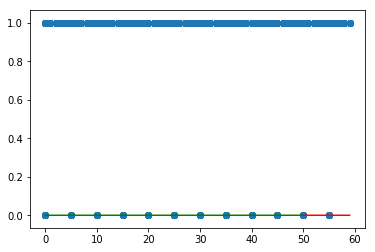

In [172]:
#plot the class predictions
plt.scatter(cliftonAVAIL.Minute, cliftonAVAIL.Status_Number)
plt.plot(X_train, LogReg_y_train_pred, color='green')
plt.plot(X_test, LogReg_y_test_pred, color='red')

In [173]:
#generate LogReg model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test,
                                                 LogReg_test_probs[:, 1])

In [174]:
thresholds_lr

array([ 0.266,  0.265,  0.264,  0.263,  0.262,  0.261,  0.26 ])

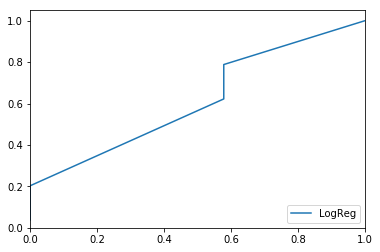

In [175]:
#plot LR and RF model ROC curves
sns.mpl.pyplot.plot(fpr_lr, tpr_lr, label='LogReg')

sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc='lower right')
#sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
#sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [176]:
LogReg_test_probs[:, 1] > .24

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

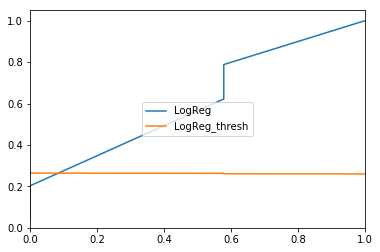

In [177]:
#plot LogReg model ROC curves
sns.mpl.pyplot.plot(fpr_lr, tpr_lr, label="LogReg")
sns.mpl.pyplot.plot(fpr_lr, thresholds_lr, label="LogReg_thresh")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="center")
#sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
#sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

In [178]:
#classification tree time

cliftonTRAIN = cliftonAVAIL[cliftonAVAIL['FormattedDatetime'] < '2017-11-01 00:00:00']
cliftonTEST = cliftonAVAIL[cliftonAVAIL['FormattedDatetime'] >= '2017-11-01 00:00:00']

CT_features_cols = ['Hour', 'Minute', 'Period']
CT_X_train = cliftonTRAIN[CT_features_cols]
CT_y_train = cliftonTRAIN.Status_Number

CT_X_test = cliftonTEST[CT_features_cols]
CT_y_test = cliftonTEST.Status_Number

In [179]:
#fit a classification tree with max_depth=3 on all of the training data

clifton_class_tree = DecisionTreeClassifier(max_depth=3, random_state=1)
clifton_class_tree.fit(CT_X_train, CT_y_train)

CT_pred = clifton_class_tree.predict(CT_X_test)

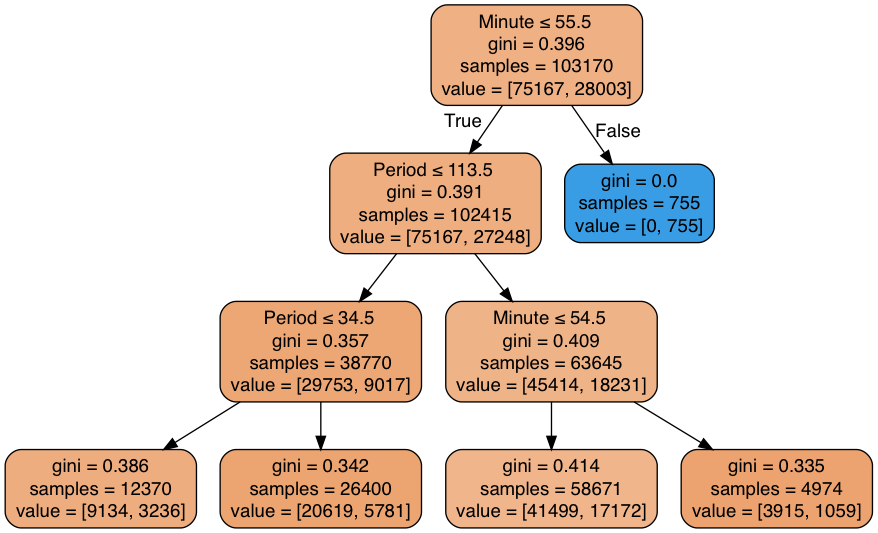

In [180]:
dot_data_clifton = StringIO()
export_graphviz(
    clifton_class_tree,
    out_file=dot_data_clifton,
    feature_names=CT_X_train.columns.tolist(),
    filled=True,
    rounded=True,
    special_characters=True)

clifton_graph = pydotplus.graph_from_dot_data(dot_data_clifton.getvalue())
Image(clifton_graph.create_png())

In [181]:
#compute the feature importances
pd.DataFrame({
    'feature': CT_features_cols,
    'importance': clifton_class_tree.feature_importances_
})

,feature,importance
0,Hour,0.000000
1,Minute,0.835514
2,Period,0.164486


In [182]:
"""ensemble time"""
bagreg = BaggingRegressor(DecisionTreeRegressor(),
                          n_estimators=500, bootstrap=True,
                          oob_score=True, random_state=1234)
#fit and predict
bagreg.fit(CT_X_train, CT_y_train)
y_pred_bag = bagreg.predict(CT_X_test)
y_pred_bag

array([ 0.22355281,  0.20460215,  0.21606583, ...,  1.        ,
        1.        ,  1.        ])

In [183]:
#calculate RMSE
print("Bagged RMSE with 500 trees:", np.sqrt(metrics.mean_squared_error(CT_y_test, y_pred_bag)))

Bagged RMSE with 500 trees: 0.222255406068


In [184]:
#random forest of 500 trees

RF_features_cols = ['Hour', 'Minute', 'Period']
RF_X_train = cliftonTRAIN[RF_features_cols]
RF_y_train = cliftonTRAIN.Status_Number

RF_X_test = cliftonTEST[RF_features_cols]
RF_y_test = cliftonTEST.Status_Number

rf = RandomForestRegressor(
    n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
rf.fit(RF_X_train, RF_y_train)
y_pred_rf = rf.predict(RF_X_test)

In [185]:
#let's compute feature importances for random forest n=500
pd.DataFrame({
    'feature': RF_features_cols,
    'importance': rf.feature_importances_
}).sort_values(
    by='importance', ascending=False)

,feature,importance
1,Minute,0.971389
2,Period,0.021806
0,Hour,0.006805


In [186]:
#let's compare the RMSE our various tree models
print("Single Tree RMSE:", np.sqrt(metrics.mean_squared_error(CT_y_test, CT_pred)))
print("Bag RMSE:", np.sqrt(metrics.mean_squared_error(CT_y_test, y_pred_bag)))
print("Random Forest RMSE:", np.sqrt(metrics.mean_squared_error(RF_y_test, y_pred_rf)))

Single Tree RMSE: 0.278282685886
Bag RMSE: 0.222255406068
Random Forest RMSE: 0.222288971165


In [187]:
"""performance metrics"""

#RMSE
linregRMSE = np.sqrt(metrics.mean_squared_error(y_LinReg, LinReg_outcome_pred))
logregRMSE = np.sqrt(metrics.mean_squared_error(y_test, LogReg_y_test_pred))
ctRMSE = np.sqrt(metrics.mean_squared_error(CT_y_test, CT_pred))
bagRMSE = np.sqrt(metrics.mean_squared_error(CT_y_test, y_pred_bag))
rfRMSE = np.sqrt(metrics.mean_squared_error(RF_y_test, y_pred_rf))

#Sensitivity/TPR
linregTPR = metrics.recall_score(y_LinReg, LinReg_outcome_pred.round())
logregTPR = metrics.recall_score(y_test, LogReg_y_test_pred)
ctTPR = metrics.recall_score(CT_y_test, CT_pred)
bagTPR = metrics.recall_score(CT_y_test, y_pred_bag.round())
rfTPR = metrics.recall_score(RF_y_test, y_pred_rf.round())

#Specificity/TNR

#Precision/PPV
linregPPV = metrics.precision_score(y_LinReg, LinReg_outcome_pred.round())
logregPPV = metrics.precision_score(y_test, LogReg_y_test_pred.round())
ctPPV = metrics.precision_score(CT_y_test, CT_pred)
bagPPV = metrics.precision_score(CT_y_test, y_pred_bag.round())
rfPPV = metrics.precision_score(RF_y_test, y_pred_rf.round())

#Negative Pred Value

#Accuracy
linregACC = metrics.accuracy_score(y_LinReg, LinReg_outcome_pred.round())
logregACC = metrics.accuracy_score(y_test, LogReg_y_test_pred.round())
ctACC = metrics.accuracy_score(CT_y_test, CT_pred)
bagACC = metrics.accuracy_score(CT_y_test, y_pred_bag.round())
rfACC = metrics.accuracy_score(RF_y_test, y_pred_rf.round())

#F1
linregF1 = metrics.f1_score(y_LinReg, LinReg_outcome_pred.round())
logregF1 = metrics.f1_score(y_test, LogReg_y_test_pred.round())
ctF1 = metrics.f1_score(CT_y_test, CT_pred)
bagF1 = metrics.f1_score(CT_y_test, y_pred_bag.round())
rfF1 = metrics.f1_score(RF_y_test, y_pred_rf.round())

/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [190]:
pd.DataFrame({'Model': ['Linear Regression',
                        'Logistic Regression',
                        'Classification Tree',
                        'Bagged Tree',
                        'Random Forest'],
              'RMSE': [linregRMSE,logregRMSE,ctRMSE,bagRMSE,rfRMSE],
              'Sensitivity/TPR': [linregTPR,logregTPR,ctTPR,bagTPR,rfTPR],
              'Precision/PPV': [linregPPV,logregPPV,ctPPV,bagPPV,rfPPV],
              'Accuracy': [linregACC,logregACC,ctACC,bagACC,rfACC],
              'F1': [linregF1,logregF1,ctF1,bagF1,rfF1],
             }, columns = ['Model', 'RMSE', 'Sensitivity/TPR', 'Precision/PPV', 'Accuracy', 'F1'])

,Model,RMSE,Sensitivity/TPR,Precision/PPV,Accuracy,F1
0,Linear Regression,0.428139,0.000000,0.0,0.758134,0.000000
1,Logistic Regression,0.489531,0.000000,0.0,0.760360,0.000000
2,Classification Tree,0.278283,0.062579,1.0,0.922559,0.117787
3,Bagged Tree,0.222255,0.764223,1.0,0.980522,0.866356
4,Random Forest,0.222289,0.764223,1.0,0.980522,0.866356
